In [1]:
import ADerrors as AD
import HDF5
import Plots
import Statistics as Stats
using LaTeXStrings
import CorrelatorAnalysis as CA

Read the correlator from the HDF5 file

In [2]:
# Read correlator
file_path = "../test/data/correlator2.hdf5"
file = HDF5.h5open(file_path)
corr = read(file["Correlator"])
close(file)
Nₜ, N_src, N_cnfg = size(corr)

(64, 8, 1612)

## Nonfolded correlator

First we do the full analysis for the nonfolded correlator.

First, initialize the correlator and set the lattice constant with error.

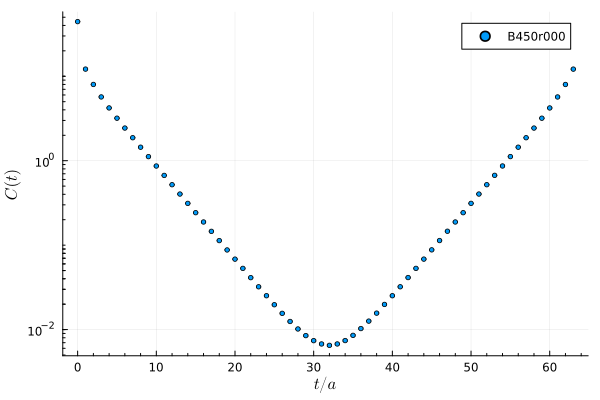

In [3]:
mcid = "B450r000"

# Lattice spacing: a = 0.0762 fm
a = AD.uwreal([0.0762, 0], "a")/CA.ħc  # 1/MeV
unit = "MeV"

corr_src_mean = Stats.mean(real(corr), dims=2)[:, 1, :]
Cₜ = CA.uwreal_array(corr_src_mean, mcid, :auto)

p = CA.plot_correlator(Cₜ)
display(p)

Autocorrelation of the correlator at time 9 (index 10)

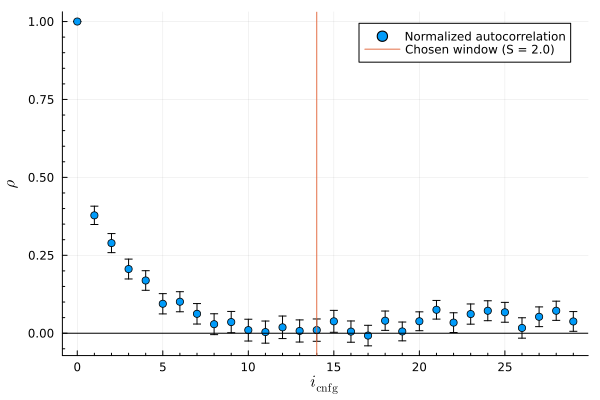

In [4]:
CA.plot_autocorrelation(Cₜ[10], mcid)

Compute the effective energy (using the $\cosh$ version).

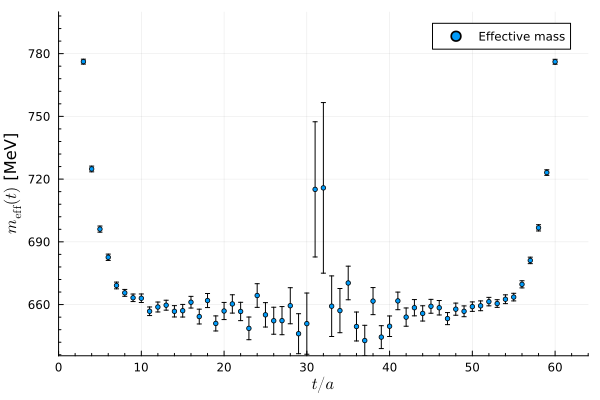

In [5]:
am_eff = CA.effective_energy(Cₜ, :cosh)

p = Plots.plot(xlim=[0, 64], ylim=[:auto, 800])
CA.plot_effective_energy!(am_eff/a, unit=unit)
display(p)

We perform a constant fit to effective energy plateau to compute the ground state energy.

We compute the value of the pion mass in MeV using the lattice spacing `a` and propagate the error. We print it together with the reduced $\chi^2$ and the p-value which are computed as described in arXiv:2209.14188.

In [6]:
plateau_range = [12, 48]

fit_result = CA.fit_plateau(am_eff, plateau_range)

am = fit_result.param[1]
m = CA.err!(am/a)

@show m
println("reduced χ² = $(fit_result.χ²_red)")
println("p-value = $(fit_result.p_value)")

m = 656.3289120840345 +/- 3.3273994367809303
reduced χ² = nothing
p-value = nothing


We plot effective energy of the correlator together with the fit to the plateau.

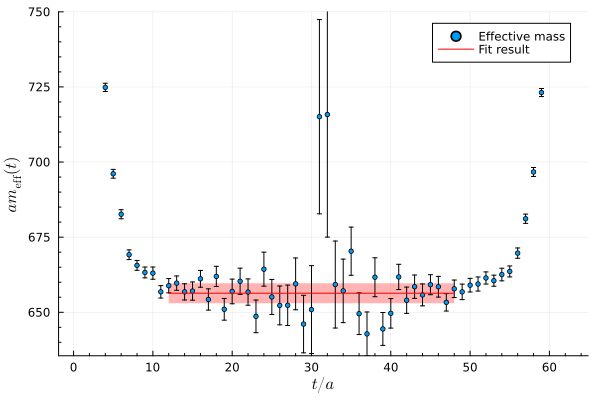

In [7]:
p = Plots.plot(ylim=[:auto, 750])
CA.plot_effective_energy!(am_eff/a)
CA.plot_error_rectangle!(m, plateau_range, unit=unit)
display(p)

Now we also make a $\cosh$ fit directly to correlator.

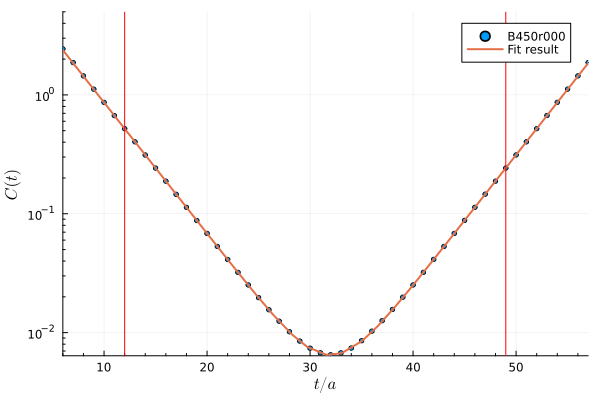

m_fit = 657.6136684743573 +/- 1.490677911448451
reduced χ² = nothing
p-value = nothing


In [8]:
corr_model(t, p) = @. p[1]*cosh(p[2]*(t - Nₜ/2))
fit_range = [plateau_range[1], plateau_range[2]+1]
xdata = range(fit_range...)
ydata = Cₜ[xdata.+1]

p0 = [7e-3, 0.25]
#= p = Plots.plot(title="Initial guess")
CA.plot_correlator!(Cₜ)
CA.plot_model!(corr_model, [0, Nₜ-1], p0)
display(p) =#

fit_result = CA.fit(corr_model, xdata, ydata, p0)
(A, am_fit) = fit_result.param

p = Plots.plot(xlims=[6, 57], ylims=[:auto, 5])
CA.plot_correlator!(Cₜ)
CA.plot_model!(corr_model, [0, Nₜ-1], AD.value.([A, am_fit]))
Plots.vline!(fit_range, label=nothing, color=:red)
display(p)

m_fit = CA.err!(am_fit/a)

@show m_fit
println("reduced χ² = $(fit_result.χ²_red)")
println("p-value = $(fit_result.p_value)")

## Folded correlator

Now we repeat the same analysis for the folded correlator.

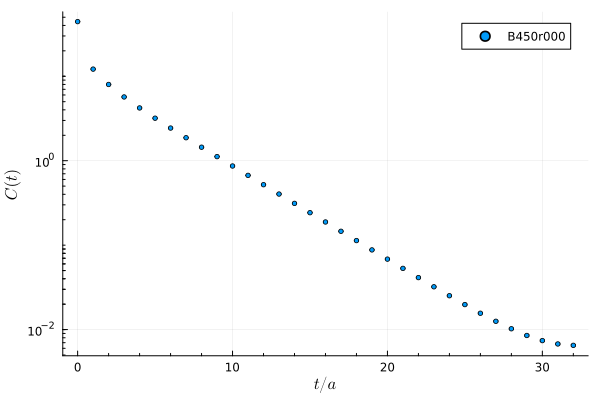

In [9]:
Cₜ_folded = CA.fold_correlator(Cₜ)

p = CA.plot_correlator(Cₜ_folded)
display(p)

Effective energy of folded correlator

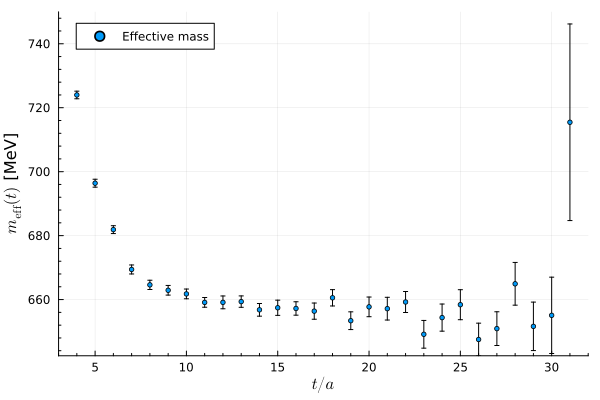

In [10]:
am_eff_folded = CA.effective_energy(Cₜ_folded, :cosh, folded=true)
CA.err!.(am_eff_folded)

p = Plots.plot(xlim=[3, :auto], ylim=[:auto, 750])
CA.plot_effective_energy!(am_eff_folded/a, unit=unit)
display(p)

Constant fit to effective energy plateau

In [11]:
plateau_range_folded = [15, 28]

fit_result = CA.fit_plateau(am_eff_folded, plateau_range_folded)

am_folded = fit_result.param[1]
m_folded = CA.err!(am_folded/a)

@show m_folded
println("reduced χ² = $(fit_result.χ²_red)")
println("p-value = $(fit_result.p_value)")

m_folded = 657.3903881959452 +/- 1.487454985885683
reduced χ² = nothing
p-value = nothing


Plot effective energy of folded correlator with fit to plateau

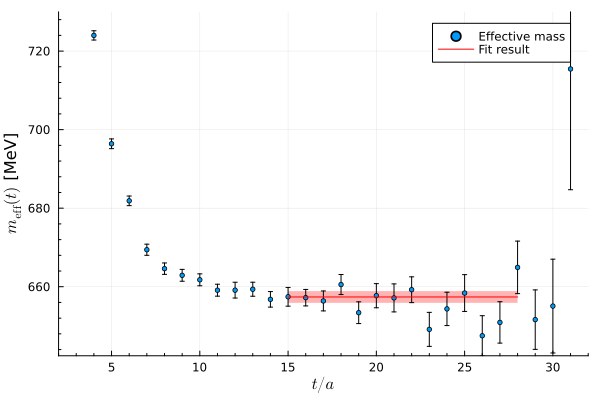

In [12]:
# Plot effective energy of folded correlator with fit to plateau
p = Plots.plot(xlim=[2, :auto], ylim=[:auto, 730])
CA.plot_effective_energy!(am_eff_folded/a, unit=unit)
CA.plot_error_rectangle!(m_folded, plateau_range_folded)
display(p)

Fit to correlator

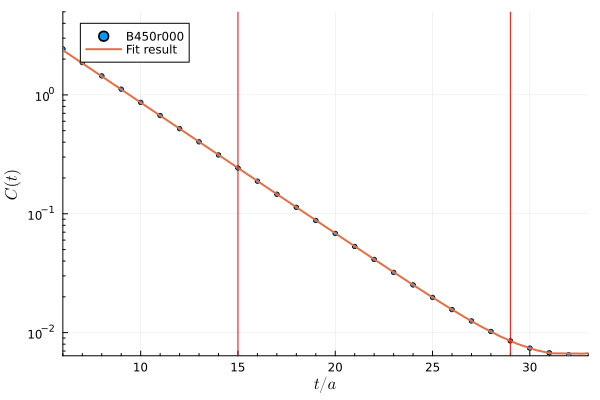

m_folded_fit = 656.6442817724721 +/- 1.5749598285870778
reduced χ² = nothing
p-value = nothing


In [13]:
fit_range_folded = [plateau_range_folded[1], plateau_range_folded[2]+1]
xdata = range(fit_range_folded...)
ydata = Cₜ_folded[xdata.+1]

p0 = [7e-3, 0.25]
#= p = Plots.plot()
CA.plot_correlator!(Cₜ_folded)
CA.plot_model!(corr_model, [0, Nₜ÷2], p0)
display(p) =#

fit_result = CA.fit(corr_model, xdata, ydata, p0)

(A_folded, am_folded_fit) = fit_result.param

p = Plots.plot(xlims=[6, 33], ylims=[:auto, 5])
CA.plot_correlator!(Cₜ_folded)
CA.plot_model!(corr_model, [0, Nₜ÷2], AD.value.([A_folded, am_folded_fit]))
Plots.vline!(fit_range_folded, label=nothing, color=:red)
display(p)

m_folded_fit = CA.err!(am_folded_fit/a)

@show m_folded_fit
println("reduced χ² = $(fit_result.χ²_red)")
println("p-value = $(fit_result.p_value)")